In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
%matplotlib widget
from geopandas import GeoSeries
import os
import h5py
from shapely.geometry import Point,Polygon
import glob
from rasterio import features

In [4]:
def extract_profile(ds,geom,dl,reverse=True):
    """
    Uses an input rasterio dataset, a geometry in the form of Geoseries (polyline) and distance between points
    to return the values of distance along the profile and the value from the dataset
    """
    # reproject the shapefile to raster projection
    geom = geom.to_crs(ds.crs)
    #extracting point coordinates from the line at the specified distance
    distance = 0
    len = geom.iloc[0].length
    while (distance<=(len)):
        pt_geom = geom.interpolate(distance)
        dicti = {'distance':distance,'geometry':pt_geom,'x':pt_geom.x.values,'y':pt_geom.y.values}
        df = gpd.GeoDataFrame(dicti)
        if distance==0:
            df_f = df.copy()
        else:
            df_f = df_f.append(df)
        distance = distance+dl
    if reverse:
        f_d = df_f['distance'].iloc[-1]
        df_f['distance'] = np.abs(df_f['distance']-f_d)
    #sampling the raster dataset values from the obtained point coordinates     
    X = df_f.x.values
    Y = df_f.y.values
    xy = np.vstack((X,Y)).T
    sampled_values = np.array(list(ds.sample(xy)))
    return df_f['distance'].values, np.ma.fix_invalid(np.reshape(sampled_values,np.shape(sampled_values)[0]))
    #return df_f['distance'].values, np.reshape(sampled_values,np.shape(sampled_values)[0])

In [5]:
def sample_values(ds,geom):
    """
    sample values from raster at the given ICESat-2 points
    using nearest neighbour algorithm
    """
    # reproject the shapefile to raster projection
    x_min,y_min,x_max,y_max = ds.bounds
    geom = geom.to_crs(ds.crs)
    #filter geom outside bounds 
    geom = geom.cx[x_min:x_max,y_min:y_max]
    X = geom.geometry.x.values
    Y = geom.geometry.y.values
    xy = np.vstack((X,Y)).T
    sampled_values = np.array(list(ds.sample(xy)))
    return geom.x_atc.values, np.ma.fix_invalid(np.reshape(sampled_values,np.shape(sampled_values)[0]))

In [6]:
def ATL06_to_dict(filename, dataset_dict):
    """
        Read selected datasets from an ATL06 file

        Input arguments:
            filename: ATl06 file to read
            dataset_dict: A dictinary describing the fields to be read
                    keys give the group names to be read, 
                    entries are lists of datasets within the groups
        Output argument:
            D6: dictionary containing ATL06 data.  Each dataset in 
                dataset_dict has its own entry in D6.  Each dataset 
                in D6 contains a list of numpy arrays containing the 
                data
    """
    
    D6=[]
    pairs=[1, 2, 3]
    beams=['l','r']
    # open the HDF5 file
    with h5py.File(filename) as h5f:
        # loop over beam pairs
        for pair in pairs:
            # loop over beams
            for beam_ind, beam in enumerate(beams):
                # check if a beam exists, if not, skip it
                if '/gt%d%s/land_ice_segments' % (pair, beam) not in h5f:
                    continue
                # loop over the groups in the dataset dictionary
                temp={}
                for group in dataset_dict.keys():
                    for dataset in dataset_dict[group]:
                        DS='/gt%d%s/%s/%s' % (pair, beam, group, dataset)
                        # since a dataset may not exist in a file, we're going to try to read it, and if it doesn't work, we'll move on to the next:
                        try:
                            temp[dataset]=np.array(h5f[DS])
                            # some parameters have a _FillValue attribute.  If it exists, use it to identify bad values, and set them to np.NaN
                            if '_FillValue' in h5f[DS].attrs:
                                fill_value=h5f[DS].attrs['_FillValue']
                                bad = temp[dataset]==fill_value
                                temp[dataset]=np.float64(temp[dataset])
                                temp[dataset][bad]=np.NaN
                        except KeyError as e:
                            pass
                if len(temp) > 0:
                    # it's sometimes convenient to have the beam and the pair as part of the output data structure: This is how we put them there.
                    temp['pair']=np.zeros_like(temp['h_li'])+pair
                    temp['beam']=np.zeros_like(temp['h_li'])+beam_ind
                    temp['filename']=filename
                    D6.append(temp)
    return D6

In [7]:
dataset_dict={'land_ice_segments':['h_li', 'delta_time','longitude','latitude'], 'land_ice_segments/ground_track':['x_atc']}

In [8]:
def point_covert(row):
    geom = Point(row['longitude'],row['latitude'])
    return geom

In [9]:
def ATL06_2_gdf(ATL06_fn,dataset_dict):
    """
    function to convert ATL06 hdf5 to geopandas dataframe, containing columns as passed in dataset dict
    Used Ben's ATL06_to_dict function
    """
    if ('latitude' in dataset_dict['land_ice_segments']) != True:
        dataset_dict['land_ice_segments'].append('latitude')
    if ('longitude' in dataset_dict['land_ice_segments']) != True:
        dataset_dict['land_ice_segments'].append('longitude')
    #use Ben's Scripts to convert to dict
    data_dict = ATL06_to_dict(ATL06_fn,dataset_dict)
    #this will give us 6 tracks
    i = 0
    for track in data_dict:
        #1 track
        #convert to datafrmae
        df = pd.DataFrame(track)
        df['p_b'] = str(track['pair'][0])+'_'+str(track['beam'][0])
        df['geometry'] = df.apply(point_covert,axis=1)
        if i==0:
            df_final = df.copy()
        else:
            df_final = df_final.append(df)
        i = i+1
    gdf_final = gpd.GeoDataFrame(df_final,geometry='geometry',crs={'init':'epsg:4326'})
    return gdf_final

In [10]:
ATL06_list = glob.glob('/home/jovyan/data/gm_noCoverage_ICESat2/*.h5')

In [11]:
ATL06_fn = '/home/jovyan/data/gm_noCoverage_ICESat2/processed_ATL06_20181110092841_06530106_001_01.h5'

In [12]:
dem_fn = '/home/jovyan/data/USCOGM20160604f1a1_bareDEM_3p0m.tif'
ds = rasterio.open(dem_fn)

In [13]:
ATL06_gdf = ATL06_2_gdf(ATL06_fn,dataset_dict)
ATL06_gdf = ATL06_gdf.to_crs(ds.crs)

In [14]:
dem = ds.read(1)
dem = np.ma.masked_less_equal(dem,0)

In [15]:
xmin,ymin,xmax,ymax = ds.bounds

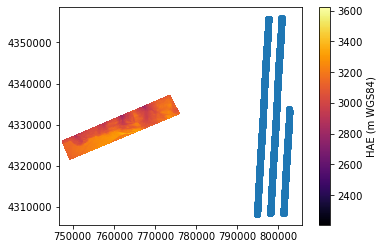

In [16]:
fig,ax = plt.subplots()
im = ax.imshow(dem,cmap='inferno',extent=[xmin,xmax,ymin,ymax])
plt.colorbar(im,label='HAE (m WGS84)')
ATL06_gdf.plot(ax=ax)

In [17]:
ATL06_gdf_list = [ATL06_2_gdf(x,dataset_dict) for x in ATL06_list]
ATL06_gdf_list = [x.to_crs(ds.crs) for x in ATL06_gdf_list]

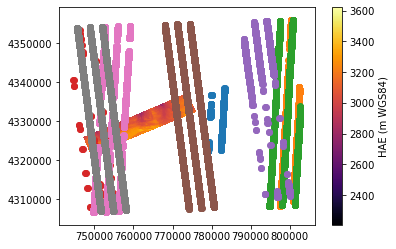

In [18]:
fig,ax = plt.subplots()
im = ax.imshow(dem,cmap='inferno',extent=[xmin,xmax,ymin,ymax])
plt.colorbar(im,label='HAE (m WGS84)')
for gdf in ATL06_gdf_list:
    gdf.plot(ax=ax)
#ATL06_gdf.plot(ax=ax)

In [53]:
x_atc,z = sample_values(ds,ATL06_gdf_list[6])

In [59]:
z = np.ma.masked_equal(z,-9999)

In [63]:
x_atc = np.ma.array(x_atc,mask = z.mask)

In [67]:
fig,ax = plt.subplots()
ax.scatter(x_atc,z)
ax.scatter(ATL06_gdf_list[6].x_atc.values,ATL06_gdf_list[6].h_li.values,marker='^',c='red',s=1)
#im = ax.imshow(dem,cmap='inferno',extent=[xmin,xmax,ymin,ymax])
#plt.colorbar(im,label='HAE (m WGS84)')
#for gdf in ATL06_gdf_list:
 #   gdf.plot(ax=ax)
#ATL06_gdf.plot(ax=ax)

FigureCanvasNbAgg()

In [104]:
def sample_near_nbor(ds,geom):
    """
    sample values from raster at the given ICESat-2 points
    using nearest neighbour algorithm
    """
    # reproject the shapefile to raster projection
    x_min,y_min,x_max,y_max = ds.bounds
    geom = geom.to_crs(ds.crs)
    #filter geom outside bounds 
    geom = geom.cx[x_min:x_max,y_min:y_max]
    X = geom.geometry.x.values
    Y = geom.geometry.y.values
    xy = np.vstack((X,Y)).T
    sampled_values = np.array(list(ds.sample(xy)))
    no_data = get_ndv(ds)
    sample = np.ma.fix_invalid(np.reshape(sampled_values,np.shape(sampled_values)[0]))
    sample = np.ma.masked_equal(sample,no_data)
    x_atc = np.ma.array(geom.x_atc.values,mask = sample.mask)
    return x_atc, sample

In [21]:
gda_lib.sample_near_nbor(ds,ATL06_gdf_list[6])

(masked_array(data=[--, --, --, ..., --, --, --],
              mask=[ True,  True,  True, ...,  True,  True,  True],
        fill_value=1e+20), masked_array(data=[--, --, --, ..., --, --, --],
              mask=[ True,  True,  True, ...,  True,  True,  True],
        fill_value=-9999.0,
             dtype=float32))

In [20]:
gdf_6 = ATL06_gdf_list[6]

In [22]:
gdf_6_p1b1 = gdf_6.loc[gdf_6['p_b']=='1.0_0.0']


In [23]:
x_atc_p1b1,z_hp_p1b1 = gda_lib.sample_near_nbor(ds,gdf_6_p1b1)

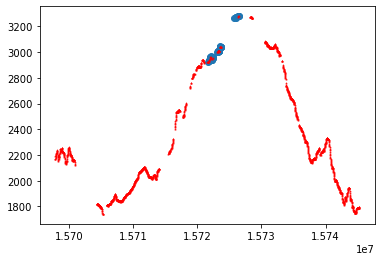

In [24]:
fig,ax = plt.subplots()
ax.scatter(x_atc_p1b1,z_hp_p1b1)
ax.scatter(gdf_6_p1b1.x_atc.values,gdf_6_p1b1.h_li.values,marker='^',c='red',s=1)

In [25]:
df1,df2,df3,df4,df5,df6 = [x for x_,x in ATL06_gdf_list[6].groupby(ATL06_gdf_list[6]['p_b'])]

In [26]:
df_list = [df1,df2,df3,df4,df5,df6]

Text(0.5, 0.98, 'Nearest neighbour sampling')

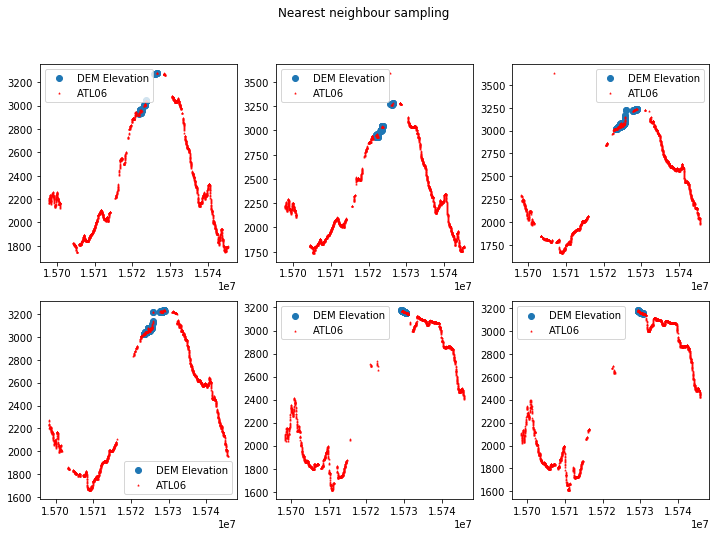

In [30]:
fig,axs = plt.subplots(2,3,figsize=(12,8))
for i,ax in enumerate(fig.axes):
    x_atc,z_hp = gda_lib.sample_near_nbor(ds,df_list[i])
    ax.scatter(x_atc,z_hp,label='DEM Elevation')
    ax.scatter(df_list[i].x_atc.values,df_list[i].h_li.values,marker='^',c='red',s=1,label='ATL06')
    ax.legend()   
plt.suptitle('Nearest neighbour sampling')
#ax.scatter(gdf_6_p1b1.x_atc.values,gdf_6_p1b1.h_li.values,marker='^',c='red',s=1)

Text(0.5, 0.98, 'Buffer sampling with window radius of 20 m')

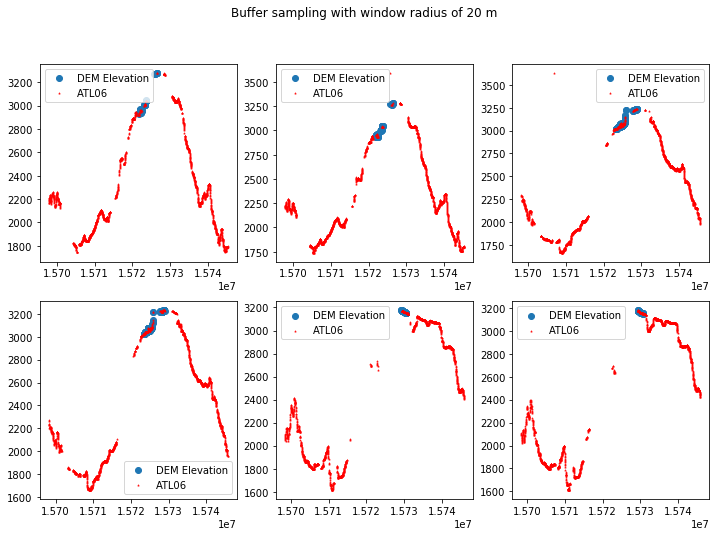

In [31]:
fig,axs = plt.subplots(2,3,figsize=(12,8))
for i,ax in enumerate(fig.axes):
    x_atc,z_hp = gda_lib.buffer_sampler(ds,df_list[i],20)
    ax.scatter(x_atc,z_hp,label='DEM Elevation')
    ax.scatter(df_list[i].x_atc.values,df_list[i].h_li.values,marker='^',c='red',s=1,label='ATL06')
    ax.legend()   
plt.suptitle('Buffer sampling with window radius of 20 m')
#ax.scatter(gdf_6_p1b1.x_atc.values,gdf_6_p1b1.h_li.values,marker='^',c='red',s=1)

In [47]:
def mask_by_shp(geom,array,ds,reverse=False): 
    if (type(ds) == rasterio.io.DatasetReader):
        transform = ds.transform
    else:
        transform = affine.Affine.from_gdal(*ds.GetGeoTransform())
    shp = features.rasterize(geom,out_shape=np.shape(array),fill=-9999,transform=transform,dtype=float)
    shp_mask = np.ma.masked_where(shp==-9999,shp)
    if reverse:
        req_mask = ~shp_mask.mask
    else:
        req_mask = shp_mask.mask
    masked_array = np.ma.array(array,mask=req_mask)
    return masked_array

In [53]:
def median_profile(ds,geom,buff,val='med'):
    """
    sample values from raster at the given ICESat-2 points
    using a buffer distance, and return median/mean
    """
    # reproject the shapefile to raster projection
    x_min,y_min,x_max,y_max = ds.bounds
    geom = geom.to_crs(ds.crs)
    #filter geom outside bounds 
    geom = geom.cx[x_min:x_max,y_min:y_max]
    #adjust for no data
    no_data = get_ndv(ds)
    array = ds.read(1)
    array = np.ma.masked_equal(array,no_data)
    geom['geometry'] = geom.geometry.buffer(buff)
   # print(type(geom))
    out_list = []
    for i,row in geom.iterrows():
       # print(type(row))
        poly_array =  mask_by_shp(GeoSeries(row.geometry),array,ds)
        if val == 'med':
            out = np.ma.median(poly_array)
        else:
            out = np.ma.mean(poly_array)
        out_list.append(out)
    return geom.x_atc.values, out_list

In [112]:
array = ds.read(1,masked=True)

In [54]:
median_profile(ds,df_list[2],20)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


KeyboardInterrupt: 

In [115]:
ds.nodata ==None

True

In [116]:
ds.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 9955, 'height': 5857, 'count': 1, 'crs': CRS.from_epsg(32612), 'transform': Affine(3.0, 0.0, 746619.0,
       0.0, -3.0, 4338012.0), 'tiled': False, 'interleave': 'band'}

In [4]:
import gdal


In [5]:
band = gdal.Open(dem_fn,2).GetRasterBand(1)

In [6]:
band

<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7fba046ed4e0> >

In [ ]:
band.GetNoDataValue()

In [1]:
band.GetNoDataValue()

NameError: name 'band' is not defined

In [10]:
def get_ndv(ds):
    no_data = ds.nodatavals[0]
    if no_data == None:
        #this means no data is not set in tif tag, nead to cheat it from raster
        ndv = ds.read(1)[0,0]
    else:
        ndv = no_data
    return ndv

In [67]:
dem

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

In [57]:
df_buffered = df_list[5].copy()
df_buffered['geometry'] = df_buffered.geometry.buffer(20)

In [68]:
dem_filled = np.ma.filled(dem,np.nan)

In [73]:
dem_filled

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [69]:
import rasterstats as rs

In [91]:
profile_stats = gpd.GeoDataFrame.from_features(rs.zonal_stats(df_buffered,dem,affine=ds.transform,geojson_out=True,stats="median",nodata=-9999))

In [92]:
profile_stats = profile_stats.rename(columns={'median':'med'})

In [94]:
profile_stats.head()

,beam,delta_time,filename,geometry,h_li,latitude,longitude,med,p_b,pair,x_atc
0,1.0,2.992328e+07,/home/jovyan/data/gm_noCoverage_ICESat2/proces...,"POLYGON ((752773.3263820586 4354161.339010223,...",2109.107178,39.299962,-108.068931,NaN,3.0_1.0,3.0,1.569845e+07
1,1.0,2.992328e+07,/home/jovyan/data/gm_noCoverage_ICESat2/proces...,"POLYGON ((752771.9874215935 4354141.33305324, ...",2103.466797,39.299782,-108.068954,NaN,3.0_1.0,3.0,1.569847e+07
2,1.0,2.992328e+07,/home/jovyan/data/gm_noCoverage_ICESat2/proces...,"POLYGON ((752770.6514802576 4354121.325010256,...",2094.860352,39.299603,-108.068977,NaN,3.0_1.0,3.0,1.569849e+07
3,1.0,2.992328e+07,/home/jovyan/data/gm_noCoverage_ICESat2/proces...,"POLYGON ((752769.3620773242 4354101.314930591,...",2086.094971,39.299423,-108.068999,NaN,3.0_1.0,3.0,1.569851e+07
4,1.0,2.992328e+07,/home/jovyan/data/gm_noCoverage_ICESat2/proces...,"POLYGON ((752768.0751188451 4354081.304702571,...",2074.346680,39.299243,-108.069021,NaN,3.0_1.0,3.0,1.569853e+07


In [90]:
fig,ax = plt.subplots()
ax.scatter(profile_stats.x_atc.values,profile_stats.med.values)

FigureCanvasNbAgg()

In [114]:
def buffer_sampler(ds,geom,buffer,val='median',ret_gdf=False):
    """
    sample values from raster at the given ICESat-2 points
    using a buffer distance, and return median/mean or a full gdf ( if return gdf=True)
    Inputs = rasterio dataset, Geodataframe containing points, buffer distance, output value = median/mean (default median)
    and output format list of x_atc,output_value arrays (default) or  full gdf
    """
    ndv = get_ndv(ds)
    array = ds.read(1)
    gt = ds.transform
    stat = val
    geom = geom.to_crs(ds.crs)
    geom['geometry'] = geom.geometry.buffer(buffer)
    json_stats = rs.zonal_stats(geom,array,affine=gt,geojson_out=True,stats=stat,nodata=ndv)
    gdf = gpd.GeoDataFrame.from_features(json_stats)
    if val =='median':
        gdf = gdf.rename(columns={'median':'med'})
        call = 'med'
    else:
        gdf = gdf.rename(columns={'mean':'avg'})
        call = 'avg'
    if ret_gdf:
        out_file = gdf
    else:
        out_file = [gdf.x_atc.values,gdf[call].values]
    return out_file

In [1]:
from topolib import gda_lib

In [29]:
x,y = gda_lib.buffer_sampler(ds,df_list[5],20,'mean')

In [32]:
!pwd

/home/jovyan/topohack/ShashankBice
